# Imports

I made some necessary imports. Also, I imported the Preprocessing and TabularModel class from the directory.

In [1]:
from Data_Preprocessing import Preprocessing
from model import TabularModel
import torch
import torch.nn as nn
import time
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

# Getting the data

Next I created an object of the preprocessing class using the NYCTaxiFares.csv file and preprocessed the data. After that the data was split into half with 60,000 records in training and test set.

In [2]:
data_prep= Preprocessing('./Data/NYCTaxiFares.csv')
data_prep.haversine_distance()
data_prep.create_datetime_columns()
data_prep.separate_columns()
data_prep.split(60000)
    
print(data_prep.df.head())
print('Priniting embedding size.')
print(data_prep.emb_szs)
print('Printing number continuous variables.')
print(data_prep.conts.shape[1])
    

           pickup_datetime  fare_amount  fare_class  pickup_longitude  \
0  2010-04-19 08:17:56 UTC          6.5           0        -73.992365   
1  2010-04-17 15:43:53 UTC          6.9           0        -73.990078   
2  2010-04-17 11:23:26 UTC         10.1           1        -73.994149   
3  2010-04-11 21:25:03 UTC          8.9           0        -73.990485   
4  2010-04-17 02:19:01 UTC         19.7           1        -73.990976   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0        40.730521         -73.975499         40.744746                1   
1        40.740558         -73.974232         40.744114                1   
2        40.751118         -73.960064         40.766235                2   
3        40.756422         -73.971205         40.748192                1   
4        40.734202         -73.905956         40.743115                1   

        dist_km             EDTdate Hour AMorPM Weekday  
0  15079.107020 2010-04-19 04:17:56    4     a

# Model creation

Next an object of the TabularModel class was created as below.

In [3]:
torch.manual_seed(33)
model = TabularModel(data_prep.emb_szs, data_prep.conts.shape[1], 1, [200,100], p=0.4)

In [4]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [5]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model Training

The model was trained for 300 epochs without using the GPU. The duration of training is quite significant as shown in the below result.

In [6]:
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(data_prep.cat_train, data_prep.con_train)
    loss = torch.sqrt(criterion(y_pred, data_prep.y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.48451519
epoch:  26  loss: 11.92913628
epoch:  51  loss: 11.22795773
epoch:  76  loss: 10.21572399
epoch: 101  loss: 8.93678951
epoch: 126  loss: 7.69734859
epoch: 151  loss: 6.36573362
epoch: 176  loss: 5.00858259
epoch: 201  loss: 3.99299026
epoch: 226  loss: 3.57665467
epoch: 251  loss: 3.51338696
epoch: 276  loss: 3.44042730
epoch: 300  loss: 3.42139363

Duration: 953 seconds


The model loss over the epochs is shown below.

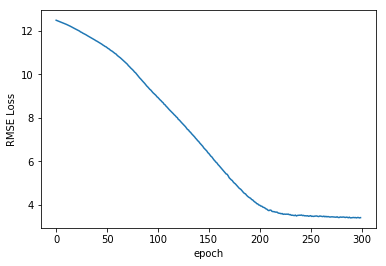

In [7]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

# Model Saving 

The model weights were saved after training as a .pt file.

In [8]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel_cpu.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

# Model Evaluation

The model was evaluated on the RMSE. It gave a quite a good RMSE.

In [10]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(data_prep.cat_test, data_prep.con_test)
    loss = torch.sqrt(criterion(y_val, data_prep.y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.38582802
